# **PROYECTO COVID-19**

In [25]:
import cv2
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import os
import shutil
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
%matplotlib inline

Definimos la funcion para leer imagenes y aumentar el tamaño de nuestro conjunto de datos, utilizando:
- Ruido Gaussiano
- Volteando verticalmente

In [2]:
def lectura(subdirectorio,fichero,path="Dataset/"):
    if(os.path.exists(path+subdirectorio)):
        listaImagenes = os.listdir(path+subdirectorio)
        datos = []

        for imagen in listaImagenes:
            datos.append(cv2.imread(path+subdirectorio+imagen,0))
        if(os.path.isfile(path+fichero)):
            with open(path+fichero) as fp: 
                salidas = fp.read().splitlines()
            return np.array(datos), np.array(salidas)
        else:
            print("¡Error! El fichero de salidas no existe")
    else:
        print("¡Error! El directorio no existe")

In [3]:
def tratamiento(pathImagenes="Data/", dx=256, dy=256, noiseX=5, noiseY=10):
    if(os.path.exists(pathImagenes)):
        resultado = []
        listaImagenes = os.listdir(pathImagenes)

        #Realizar un data augmentation para aumentar los datos del dataset:
        gaussian_noise = iaa.AdditiveGaussianNoise(noiseX, noiseY)
        flip_vr=iaa.Fliplr(p=1.0)

        for imagen in listaImagenes:
            Xray = cv2.resize(cv2.imread(pathImagenes+imagen,0),(dx, dy))
            resultado.append(Xray)
            resultado.append(gaussian_noise.augment_image(Xray))
            resultado.append(flip_vr.augment_image(Xray))

        return resultado
    else:
        print("¡Error! El path especificado no ha sido encontrado")
        return None

Definimos una funcion para hacer el particionamiento de los datos en train, test y val

In [4]:
def particionamiento(listaDatos, train_percent=.6, validate_percent=.2, seed=0):
    np.random.seed(seed)
    listaTrain=[]
    listaTest=[]
    listaVal=[]
    y_train = []
    y_test = []
    y_val = []
    for i,lista in enumerate(listaDatos):
        lista = np.array(lista)
        perm = np.random.permutation(len(lista))
        m = len(lista)
        train_end = int(train_percent * m)
        val_end = int(validate_percent * m) + train_end
        train = lista[perm[:train_end]]
        val = lista[perm[train_end:val_end]]
        test = lista[perm[val_end:]]
        listaTrain.extend(train)
        listaTest.extend(test)
        listaVal.extend(val)
        y_train.extend(list([i]*len(train)))
        y_test.extend(list([i]*len(test)))
        y_val.extend(list([i]*len(val)))
    
    return listaTrain, listaTest, listaVal, y_train, y_test, y_val

In [ ]:
def almacenaImagenes(train,test,val,y_train,y_test,y_val,path="Dataset/"):
    if(os.path.exists(path)):
        try:
            shutil.rmtree(path,ignore_errors=True)
            
        except OSError as e:
            print("¡Error! No se ha podido eliminar el directorio")
    
    os.mkdir(path, 0o7777)
    os.mkdir(path+"train/",0o7777)
    os.mkdir(path+"val/",0o7777)
    os.mkdir(path+"test/",0o7777)
    
    f = open(path+"train.txt", "w")
    for i,imagen in enumerate(train):
        cv2.imwrite(path+"train/Train-"+str(i)+".png",imagen)
        f.write(str(y_train[i])+"\n")
    f.close()
    
    f = open(path+"test.txt", "w")
    for i,imagen in enumerate(test):
        cv2.imwrite(path+"test/Test-"+str(i)+".png",imagen)
        f.write(str(y_test[i])+"\n")
    f.close()
    
    f = open(path+"val.txt", "w")
    for i,imagen in enumerate(val):
        cv2.imwrite(path+"val/Val-"+str(i)+".png",imagen)
        f.write(str(y_val[i])+"\n")
    f.close()

In [ ]:
#Pretratamiento de imagenes y almacenamiento de las mismas:
listaCOVID = tratamiento(pathCovid)
listaNORMAL = tratamiento(pathNormal)
listaVIRAL = tratamiento(pathViral)

listaDatos = [listaCOVID, listaNORMAL, listaVIRAL] 
train, test, val, y_train, y_test, y_val = particionamiento(listaDatos)

almacenaImagenes(train,test,val,y_train,y_test,y_val,pathImagenes)

C:\Users\julen\Anaconda3\envs\py37machlearn\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\julen\Anaconda3\envs\py37machlearn\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


El rendimiento en entrenamiento con 20 variables es de 99.86610558530987%
El rendimiento en validacion con 20 variables es de 33.582089552238806%
El rendimiento en test con 20 variables es de 34.55587392550144%


C:\Users\julen\Anaconda3\envs\py37machlearn\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\julen\Anaconda3\envs\py37machlearn\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\julen\Anaconda3\envs\py37machlearn\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


El rendimiento en entrenamiento con 30 variables es de 99.86610558530987%
El rendimiento en validacion con 30 variables es de 35.36165327210104%
El rendimiento en test con 30 variables es de 35.64469914040115%


C:\Users\julen\Anaconda3\envs\py37machlearn\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\julen\Anaconda3\envs\py37machlearn\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


El rendimiento en entrenamiento con 45 variables es de 99.86610558530987%
El rendimiento en validacion con 45 variables es de 41.10218140068886%
El rendimiento en test con 45 variables es de 39.19770773638969%


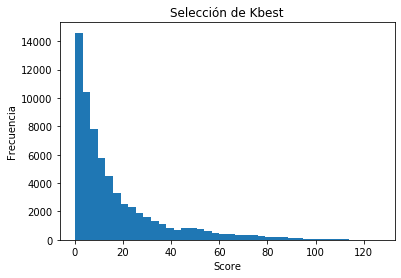

In [42]:
pathCovid = "Data/COVID-19/"
pathNormal = "Data/NORMAL/"
pathViral = "Data/Viral Pneumonia/" 
pathImagenes= "Dataset/"
fichero_train= "train.txt"
fichero_test= "test.txt"
fichero_val= "val.txt"
dx=256 
dy=256

train, y_train = lectura("train/",fichero_train,pathImagenes)
val,y_val = lectura("val/",fichero_val,pathImagenes)
test, y_test = lectura("test/",fichero_test,pathImagenes)

#Hacemos reshape de los datos para dejarlos en las dimensiones correctas(2D):
Xtrain = np.reshape(train, (train.shape[0], dx*dy))
Xtest = np.reshape(test, (test.shape[0], dx*dy))
Xval = np.reshape(val, (val.shape[0], dx*dy))

##Comprobación de las características y selección:
Kbest = SelectKBest(f_classif) #Generamos el objeto SelectKBest
Kbest.fit(Xtrain, y_train)
numPixel = list(range(dx*dy))

#Obtener los valores de Score y generar un dataFrame para su representación.
df = pd.DataFrame({'Pixeles': numPixel,'Score': Kbest.scores_.tolist()}).sort_values('Score', ascending = False)
plot = df.Score.plot(kind = 'hist', bins=40, title='Selección de Kbest')
plot.set_xlabel("Score")
plot.set_ylabel("Frecuencia")

#Seleccionar un valor de K para probar los diferentes resultados en entrenamiento, test y validacion:
valores_K = [20, 30, 45]
accTrain=[]
accTest=[]
accVal=[]

for i,k in enumerate(valores_K):
    #Seleccionar aquellos pixeles que tengan un Score mayor o igual al establecido
    pixelesSelec = df[df.Score >= k]['Pixeles'].values.tolist()
    regresion = LogisticRegression()
    
    #Entrenar el modelo con los ejemplos con el nuevo numero de caracteristicas:
    #Generar el nuevo conjunto de Train:
    X_train_tratada = Xtrain[:,pixelesSelec]
    
    #Entrenar el modelo:
    regresion.fit(X_train_tratada,y_train)
    
    #Obtener la predcción en train y el accuracy:
    predictTrain = regresion.predict(X_train_tratada)
    accTrain.append(metrics.accuracy_score(predictTrain,y_train)*100)
    
    #Generar el nuevo conjunto de Val:
    X_val_tratada = Xval[:,pixelesSelec]
    
    #Obtener la predcción en train y el accuracy:
    predictVal = regresion.predict(X_val_tratada)
    accVal.append(metrics.accuracy_score(predictVal,y_val)*100)
    
    #Generar el nuevo conjunto de Test:
    X_test_tratada = Xtest[:,pixelesSelec]
    
    #Obtener la predcción en train y el accuracy:
    predictTest = regresion.predict(X_test_tratada)
    accTest.append(metrics.accuracy_score(predictTest,y_test)*100)
    
    print('El rendimiento en entrenamiento con {} variables es de {}%'.format(k,accTrain[i]))
    print('El rendimiento en validacion con {} variables es de {}%'.format(k,accVal[i]))
    print('El rendimiento en test con {} variables es de {}%'.format(k,accTest[i]))